# Human-in-the-Loop AI Defect Classification: Exploration 
After defect image data is effectively scraped for image file paths and classification data, need to expore image/defect types and distributions.

**Exploration Goals:**
* Difference between *image types* (Topography1_Class1, DUV, etc)
* Distribution between *image types*
* Distribution between *defect types*
* Distribution between *defect location*

In [1]:
import os
import re
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image

%matplotlib inline
sns.set()

TESTFILES_PATH = os.path.join(os.getcwd(), '..', 'testing_files')
CONFIG_PATH = os.path.join(TESTFILES_PATH, 'conf.ini')
DATA_PATH = os.path.join(os.getcwd(), '..', 'raw_data')
OUTPUT_PATH = os.path.join(os.getcwd(), '..', 'cleaned_data')
LOT_ROOT = os.path.join('..', 'raw_data', 'l0Q119TeOS12PostHF')

Loading in data...

In [2]:
df = pd.read_csv(os.path.join(TESTFILES_PATH, 'master_defects_df.csv'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24368 entries, 0 to 24367
Data columns (total 11 columns):
def_num         24368 non-null int64
x               24368 non-null int64
y               24368 non-null int64
defect          24368 non-null int64
defect_label    24368 non-null object
lot             24368 non-null object
slot            24368 non-null int64
wafer_id        24368 non-null object
defect_id       24368 non-null object
image_paths     24368 non-null object
image_type      24368 non-null object
dtypes: int64(5), object(6)
memory usage: 2.0+ MB


Analyzing class distribution...

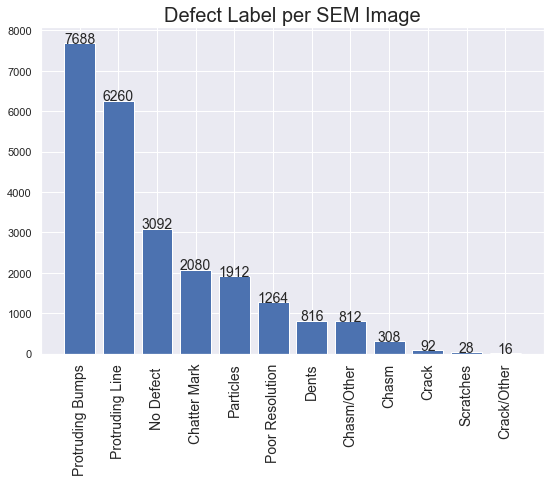

In [49]:
plt.figure(figsize=(9, 6));

defect_labels = df.defect_label.value_counts()

x = np.arange(len(defect_labels))
plt.bar(x, defect_labels)
plt.xticks(x, defect_labels.index, rotation=90, size=14)

for n, count in zip(x, defect_labels.values):
    plt.text(n, count, str(count), ha='center', size=14)

plt.title('Defect Label per SEM Image', size=20)
plt.show();

Above plots counts of defect labels, per image. It is important to note that for any given defect, there are 4-8 images. 

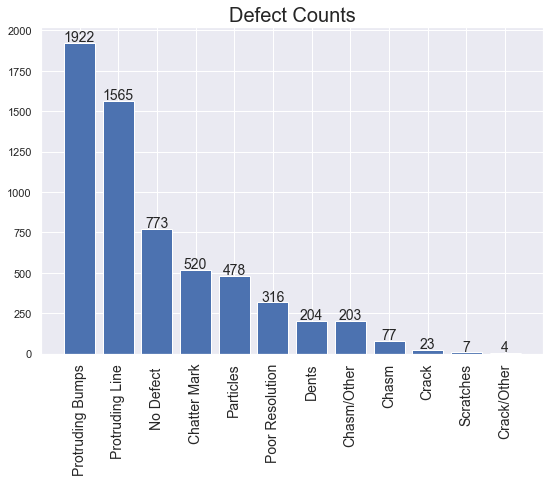

In [50]:
plt.figure(figsize=(9, 6));

topo1_df = df[df.image_type == 'Topography1_Class1']
defect_labels = topo1_df.defect_label.value_counts()

x = np.arange(len(defect_labels))
plt.bar(x, defect_labels)
plt.xticks(x, defect_labels.index, rotation=90, size=14)

for n, count in zip(x, defect_labels.values):
    plt.text(n, count + 10, str(count), ha='center', size=14)

plt.title('Defect Counts', size=20)
plt.show();

Above are the counts of unique defects, without image redundancy. A few notes for future model training:
* Will likely need to sample training data to reflect more uniform distribution, otherwise model may overfit protruding line
* May need to either drop categories [Chasm, Scratches, Crack, Residue], combine them, or reclassify them.

## Defect Type as Function of Wafer Radius 
May be interesting to see distribution of defects as a function of radius, which will directly pertain to QWE hardware. 

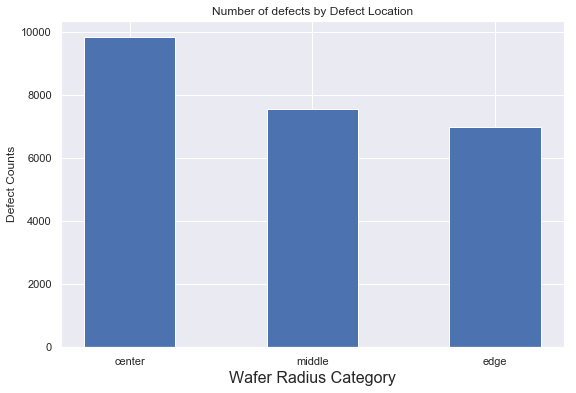

In [51]:
df['r'] = np.round(np.sqrt(df.x**2 + df.y**2) / 1000).astype(int)
df['r_cat'] = np.ceil(df.r / 50).astype(int)
df['r_cat_name'] = df.r_cat.map({1: 'center', 2:'middle', 3:'edge'})

plt.figure(figsize=(9, 6))
plt.bar([1, 2, 3], df['r_cat_name'].value_counts(), width=0.5)
plt.xlabel('Wafer Radius Category', size=16)
plt.xticks([1, 2, 3], ['center', 'middle', 'edge'])
plt.ylabel('Defect Counts')
plt.title('Number of defects by Defect Location');

Above is number of defects per wafer location. Not very interesting in that defects are sampled randomly across the wafer. May be pertinent to sample these appropriately for training. 

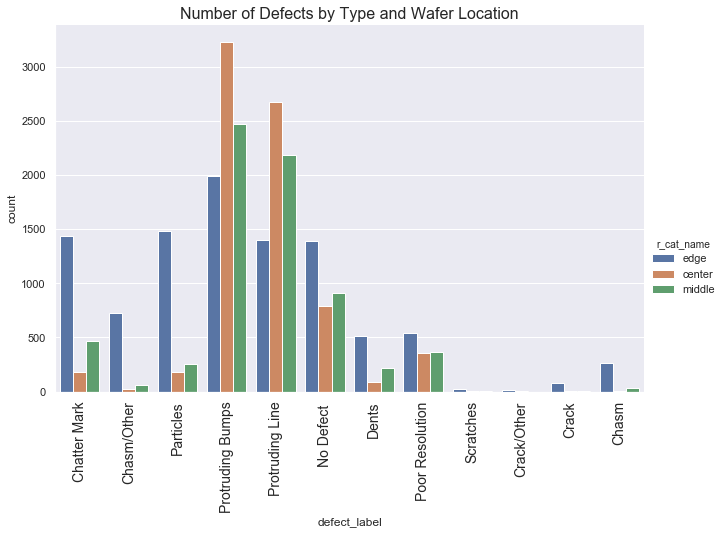

In [52]:
g = sns.catplot(x='defect_label', hue='r_cat_name', kind='count', data=df, height=6, aspect=1.5)
g.set_xticklabels(rotation=90, size=14)
plt.title('Number of Defects by Type and Wafer Location', size=16);

Above is number of defects per defect type by defect location. Interesting that protruding lines 

## Image Types 

In [53]:
df.image_type.value_counts()

Topography1_Class1     6092
Topography1_Defect1    6092
Internal_Defect1       6092
DUV_Class1             4097
OM_Class1              1562
Internal_Class1         433
Name: image_type, dtype: int64

## Image Exploration 
Analyzing nature of different image types.

In [54]:
df.defect_label.value_counts()

Protruding Bumps    7688
Protruding Line     6260
No Defect           3092
Chatter Mark        2080
Particles           1912
Poor Resolution     1264
Dents                816
Chasm/Other          812
Chasm                308
Crack                 92
Scratches             28
Crack/Other           16
Name: defect_label, dtype: int64

In [63]:
def plot_sample_images(df, image_type='Topography1_Class1', seed=3):
    np.random.seed(seed)
    image_df = df[df.image_type == image_type]
    # masking defect_labels with fewer than 50 images
    defect_counts = image_df.defect_label.value_counts()
    defect_labels = defect_counts[defect_counts > 19].index

    n_labels = len(defect_labels)
    mx, nx = (250, 250)

    fig, rows = plt.subplots(n_labels, n_labels, figsize=(12, 12))

    for i, row in enumerate(rows):
        label = defect_labels[i]
        data = image_df[image_df.defect_label == label].reset_index()
        for ax in row:
            n = np.random.randint(len(data))
            im_file = data['image_paths'][n]
            im = Image.open(im_file).resize((mx, nx))
            ax.imshow(im)
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

    for ax, row in zip(rows[:, 0], defect_labels):
        ax.set_ylabel(row, size='large', rotation=90)

    plt.suptitle(image_type, size='xx-large', weight='bold')
    plt.subplots_adjust(top=0.93);

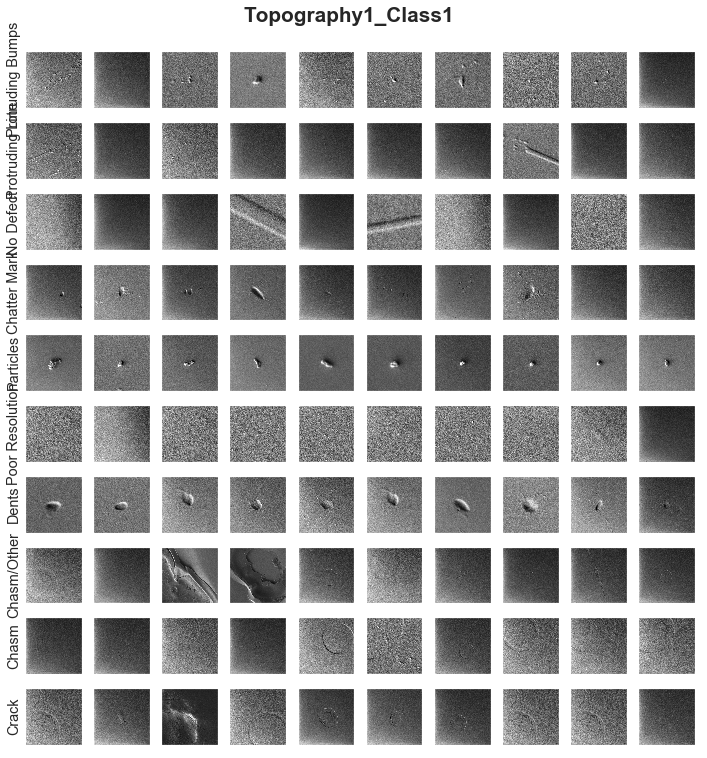

In [64]:
plot_sample_images(df)

In [68]:
topo_df = df[df.image_type == 'Topography1_Class1']

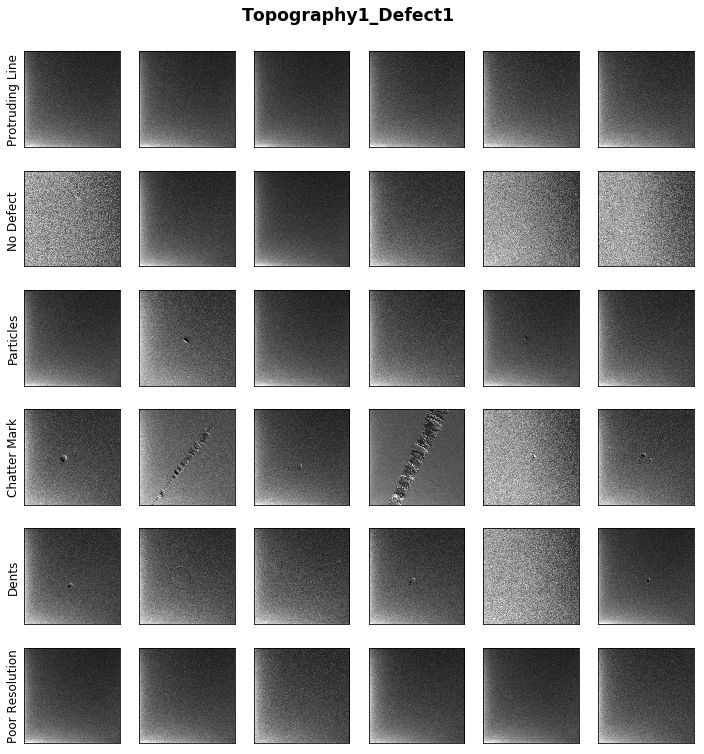

In [14]:
plot_sample_images(df, 'Topography1_Defect1')

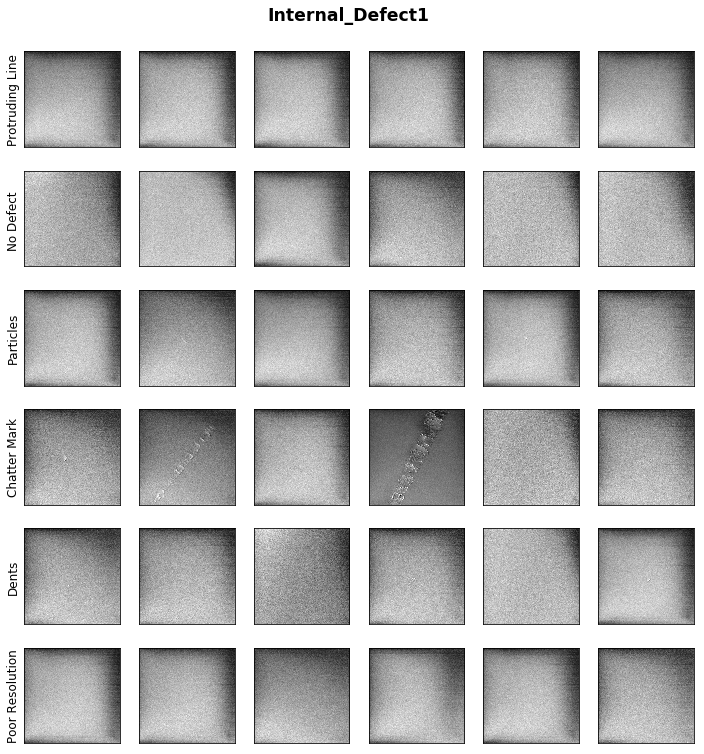

In [15]:
plot_sample_images(df, 'Internal_Defect1')

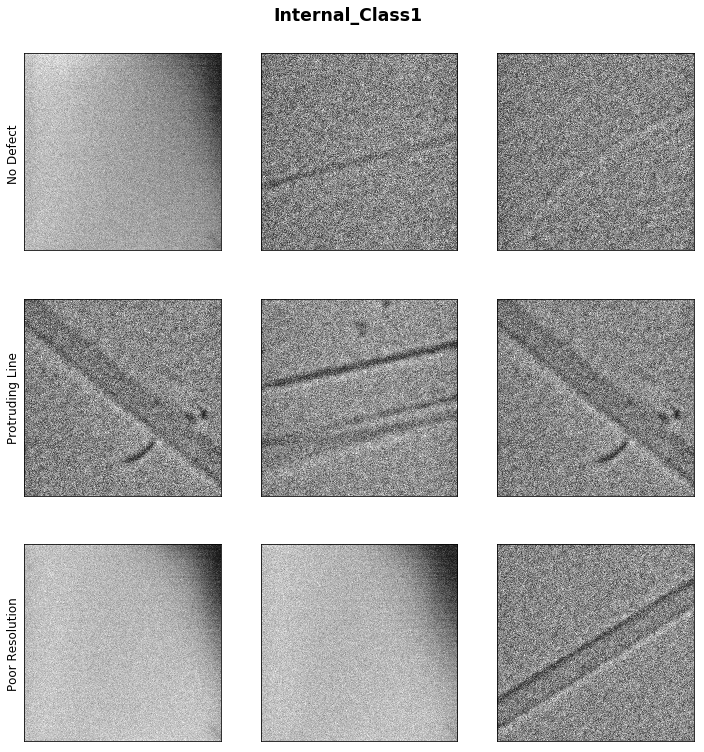

In [16]:
plot_sample_images(df, 'Internal_Class1')

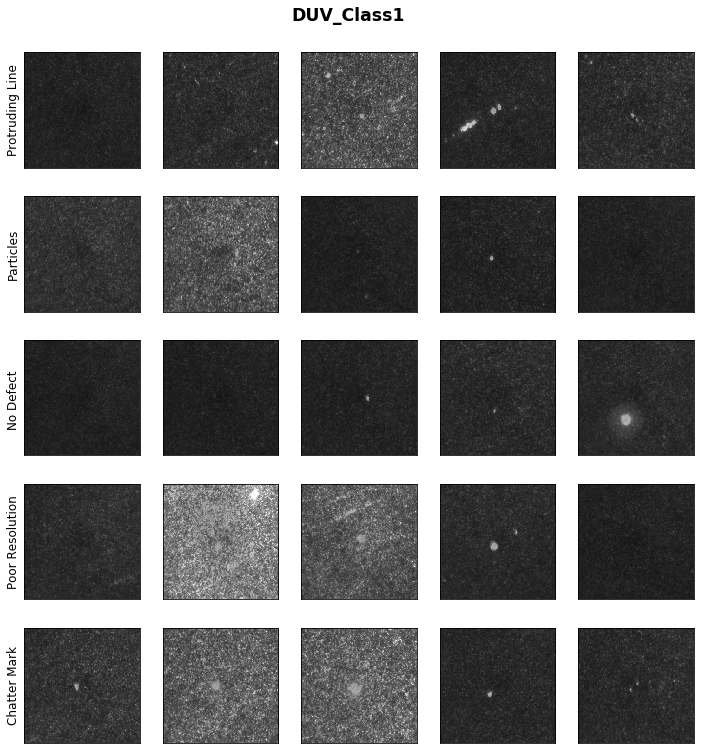

In [17]:
plot_sample_images(df, 'DUV_Class1')

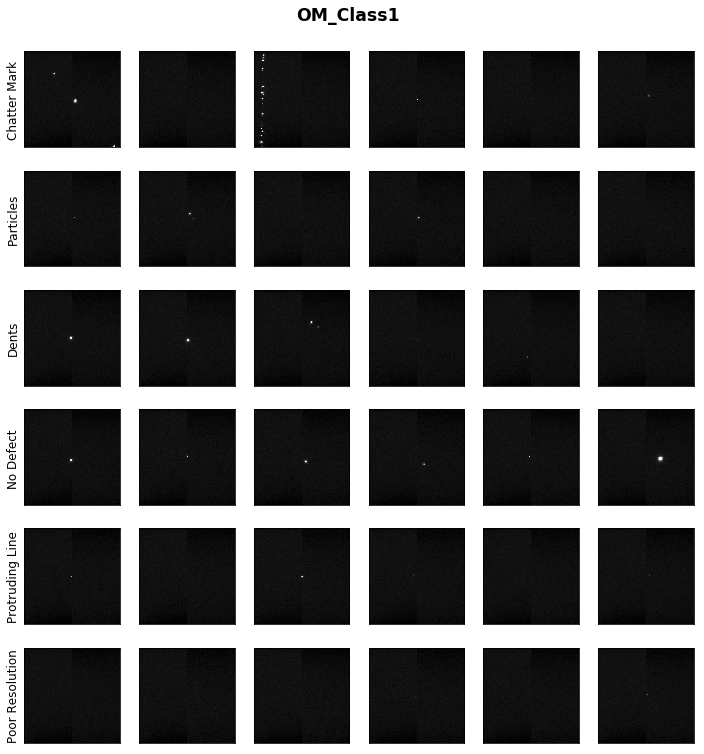

In [18]:
plot_sample_images(df, 'OM_Class1')

##### A few concerns:
* I was hoping the different image types could give the opportunity of a multi-channel input. It appears that all types except `Topography1_Class1` give consistently clear images.
* In grainy images I can see grids forming. Possibly from the interpolant in the `imshow` function
* I'm seeing protruding lines images incorrectly classified. This could mean:
    * Errors in by-hand classification
        * Might be worth running crawl on later-classified images, once engineer got the hang of it
    * Errors in data collection (I need to go back and verify.)
* Dents and Chatter Marks are hard to distinguish between each other. It might be best to combine them into one category.
* Chasm, Scratch, Crack, and Residue counts are probably too few to train from. My options are to:
    * Drop them: I'm leaning toward this option as their sum amounts to <1% of the distribution.    
    * Gather more data
* 250x250px might be a little steep from a memory standpoint. Might be prudent to explore different (lower) resolutions.
* `Poor resolution` images should be dropped from training? Images with poor resolution might be a good place for the algorithm to shine.

| Defect | Count|
| --- | --- | 
| Protruding Line | 5484 |
| No Defect | 1641 |
| Particles | 1564 |
| Chatter Mark | 1112 |
| Dents | 611 |
| Poor Resolution | 592 |
| Chasm | 48 |
| Scratches | 32 |
| Crack | 20 |
| Residue | 12 |

Plotting different resolutions to compare against 250x250px

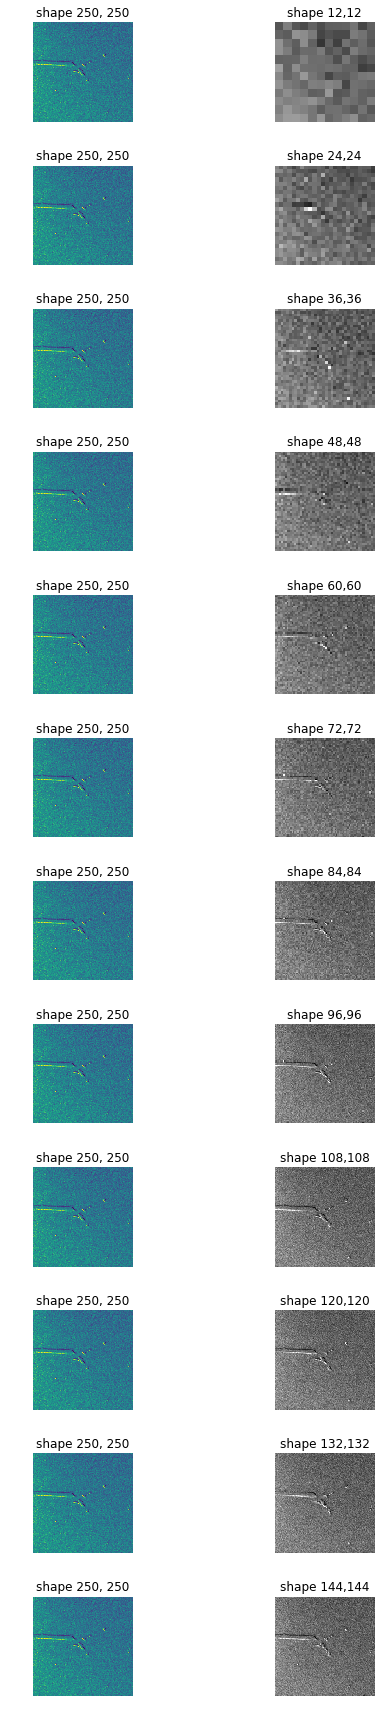

In [19]:
topo_images = np.load(os.path.join(TESTFILES_PATH, 'test_Topography1_Class1_arrays'))
topo_data = pd.read_pickle(os.path.join(TESTFILES_PATH, 'test_Topography1_Class1_targets'))

im = topo_images[1]

fig, axes = plt.subplots(12, 2, figsize=(8, 24))

for n, ax in zip([12 * i for i in range(1, 13)], axes):
    im_small = Image.fromarray(im).resize((n, n), Image.NEAREST)
    ax[0].imshow(im)
    ax[0].axis('off')
    ax[0].set_title('shape 250, 250'.format(n, n))
    ax[1].imshow(im_small)
    ax[1].set_title('shape {0},{1}'.format(n, n))
    ax[1].axis('off')
plt.tight_layout()

It looks like dimensions beyond (96, 96) have diminishing returns... I could play with this as a parameter in the training stage. 